# Setup
This notebook will explore and evaluate the performance for `GPT-4-Turbo`, `DeepSeek-Coder-33B-Instruct`, `OpenCodeInterpreter-DS-33B`, `GPT-3.5-Turbo`, `WizardCoder-33B-V1.1`, `MagiCoder-S-DS-6.7B`, `CodeLLama-70B-Instruct`, `Gemini Pro 1.0` and`Codex` across ISO 5055

In [5]:
# Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dataframe_image as dfi
import warnings
warnings.filterwarnings('ignore')

# Load sheet helper function
load_sheet = lambda x: pd.read_excel('results.xlsx', sheet_name=x)

### Plotting helpers
prompt_palette = {'short': '#bad7f5', 'medium': '#73afeb', 'long': '#004f9e', 'average':'gray'}

# Model name transformer for plotting
model_name_transformer = {'wizardcoder': 'WiCo',
                          'gpt-35-turbo': 'GPT35T',
                          'gpt-4-turbo': 'GPT4T',
                          'codellama': 'CLLam',
                          'opencodeinterpreter': 'OpCoInt',
                          'magicoder': 'MaCo',
                          'deepseeker-coder': 'DeSeCo',
                          'codex':'CoX',
                          'gemini': 'GeMi',
                          'baseline': 'Base'
                          }

colors = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6", 'grey']
model_color_mapper = dict(zip(model_name_transformer.values(), colors))

# Data Cleaning and Preprocessing

## Preprocessing Helpers
Below are helper functions for preprocessing

In [85]:
def dataframe_preprocessing(df0):
    # Copy the dataframe
    df = df0.copy()

    # Values with 0 values in any of the columns other than model and prompt with 0.01
    zerozero_one = ['errors', 'warnings', 'refactor', 'convention', 'pylint_score', 'security_low', 'max_complexity']# Standardize the columns

    # LOC normalization is also applied here as it is the same metrics
    for col in zerozero_one:
        if col != 'max_complexity':
            df[col] = df[col].apply(lambda x: 0.01 if x == 0 else x)

        if col != "security_low":
            df[col] = df[col] / df['loc']

    # Method normalization
    df['sloc_to_methods'] = df['sloc'] / df['number_of_methods']

    # Divide by maximum
    max_norms = zerozero_one + ['max_complexity', 'comments_to_loc', 'sloc_to_methods', 'memory_usage', 'multi_and_comments_to_loc']
    for col in max_norms:
        df[col] = df[col] / max(df[col])

    # Colummns with natural scales
    cols_natural_scale = {
        'mi': 100,
        'pylint_score': 10,
        'cpu':100}

    for col, scale in cols_natural_scale.items():
        df[col] = df[col] / scale

    # Inverse columns
    inverse = ['errors', 'cpu', 'warnings', 'refactor', 'convention', 'halstead_bugs', 'security_high', 'security_low', 'security_medium', 'memory_usage', 'max_complexity', 'sloc_to_methods']
    for col in inverse:
        if df[col].sum() == len(df):
            continue
        df[col] = 1 - df[col]

    # Replacing model names with shorter names
    df['model'] = df['model'].apply(lambda x: model_name_transformer[x])

    return df


# Function to partition the dataframe
def partion(df, metrics, domain = False):
    if domain:
        also_include = ['domain']
    else:
        also_include = []
    always_include = ['model','prompt'] + also_include
    return df[always_include + metrics]

## Algorithm and Domain Helpers
Below are list and dictionaries useful for seperating the dataset into ISO 5055 principal categories

In [86]:
# Metrics for each category
security_metrics = ['security_low', 'warnings', 'errors']
reliability_metrics = ['errors', 'warnings','max_complexity','halstead_bugs']
efficiency_metrics = ['cpu', 'memory_usage']
maintainability_metrics = ['mi','refactor','convention','comments_to_loc','sloc','sloc_to_methods', 'multi_and_comments_to_loc', 'halstead_effort']

# Domain parser
domain = {
    'attention': 'Machine Learning',
    'convolution': 'Machine Learning',
    'pca': 'Machine Learning',
    'huffman': 'Data Processing',
    'rabin-karp': 'Data Processing',
    'quick_sort': 'HPC',
    'monte_carlo_simulation': 'HPC',
    'page_rank': 'Data Processing',
    'strassen': 'HPC'
}

domain_palette = {
    'Machine Learning': 'red',
    'Data Processing': 'blue',
    'HPC': 'green'
}

## Loading Data

In [87]:
# Loading all data
df = pd.DataFrame()

# Loop through each sheet
for sheet in pd.ExcelFile('results.xlsx').sheet_names:

    # Skip the first sheet, it's empty
    if sheet == "Sheet":
        continue
    else:
        # Load the sheet
        df0 = load_sheet(sheet)

        # Add the algorithm column
        df0['algorithm'] = sheet
        # Concatenate the dataframes
        df = pd.concat([df, dataframe_preprocessing(df0.copy())]).groupby(['model','prompt', 'algorithm']).agg(np.mean).reset_index()


# Add average
average_df = df.groupby(['model', 'algorithm']).agg(np.mean).reset_index()
average_df['domain'] = average_df['algorithm'].apply(lambda x: domain[x])
average_df['prompt'] = 'average'

# Concatenate the dataframes
df['domain'] = df.algorithm.apply(lambda x: domain[x])
df_raw = pd.concat([df, average_df])

# Create a domain dataframe, averaging the values for each domain
domain_df = df_raw.groupby(['model', 'prompt', 'domain']).agg(np.mean).reset_index()

# Create a grouped dataframe for all domains
df = df_raw.groupby(['model', 'prompt']).agg(np.mean).reset_index()

# Maintainability
This section includes the charts for maintainability

In [88]:
# Partition dataframes for maintainability
df_maintainability = partion(df, maintainability_metrics)
df_domain_maintainability = partion(domain_df, maintainability_metrics, domain=True)

## Maintainability Index

### Domain Exploration

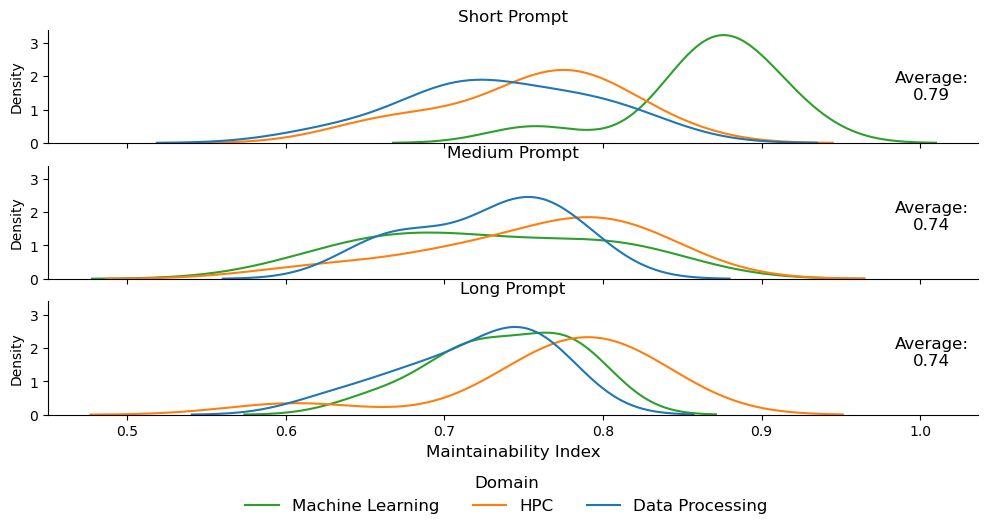

In [83]:
# Plotting Figure
fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='mi', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Maintainability Index', fontsize=12)
    axs[i].text(0.95, distance, f"Average:\n{df_domain_maintainability[df_domain_maintainability.prompt == prompt].mi.mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

### LLM Performance

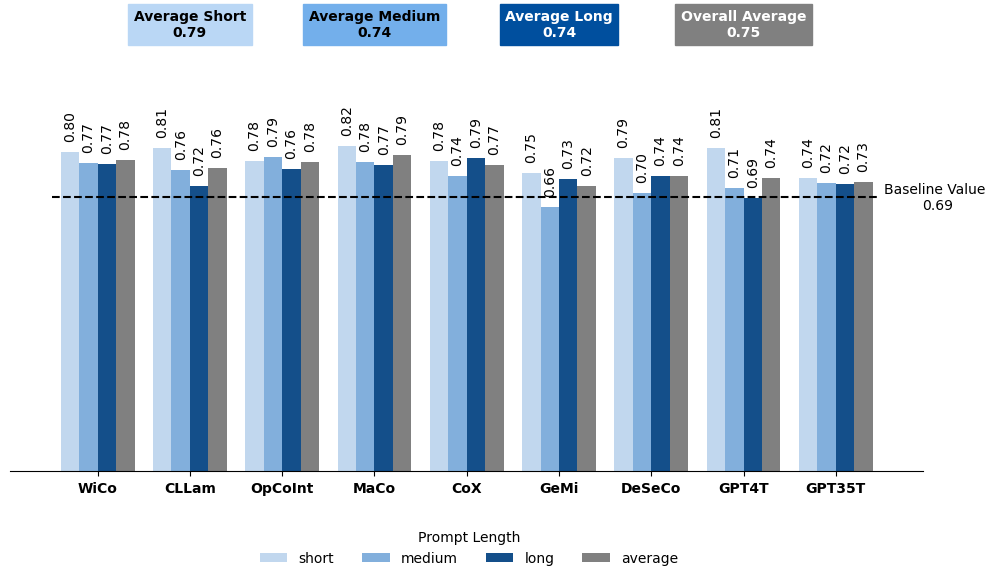

In [28]:
# Catplot
g = sns.catplot(data=df_maintainability[df_maintainability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='mi',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                errorbar=('ci', False)
                )

baseline_value = df_maintainability[df_maintainability.model == 'Base']['mi'].values[0]
short_average = df_maintainability[df_maintainability.prompt == 'short']['mi'].mean()
medium_average = df_maintainability[df_maintainability.prompt == 'medium']['mi'].mean()
long_average = df_maintainability[df_maintainability.prompt == 'long']['mi'].mean()
overall_average = df_maintainability['mi'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


## Python Coding Violations

### Domain Exploration

#### Convention

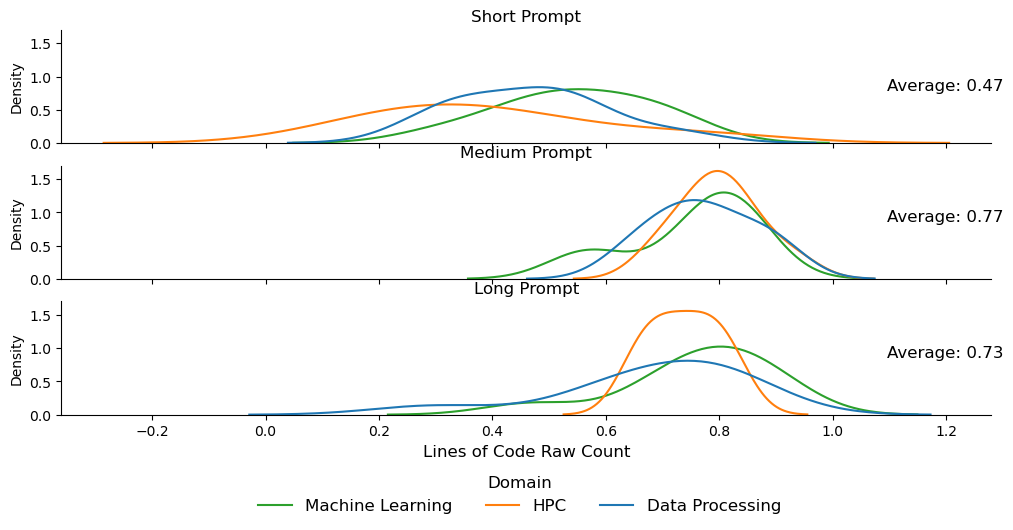

In [29]:
#df_domain_maintainability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='convention', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Lines of Code Raw Count', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_maintainability[df_domain_maintainability.prompt == prompt]['convention'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

#### Refactoring

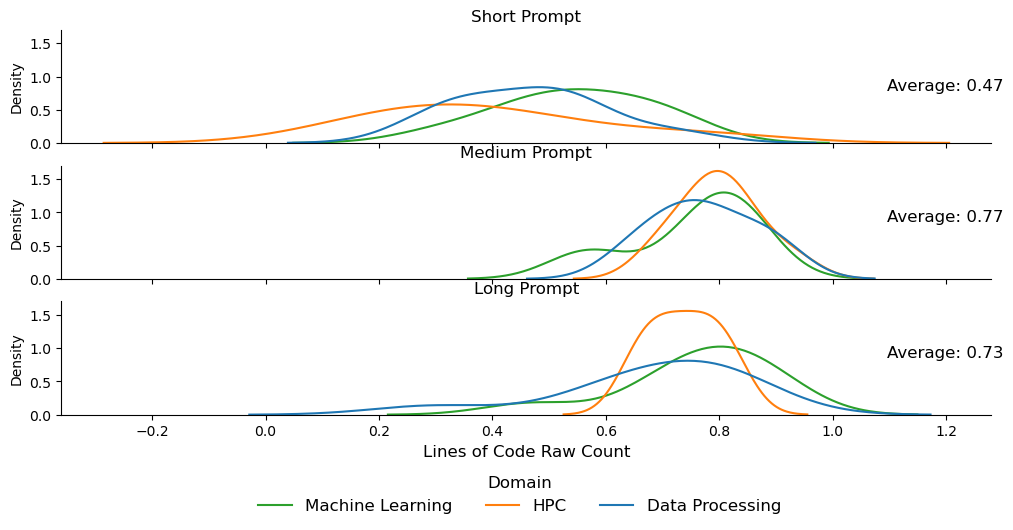

In [30]:
#df_domain_maintainability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='convention', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Lines of Code Raw Count', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_maintainability[df_domain_maintainability.prompt == prompt]['convention'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

### LLM Performance

#### Convention

In [31]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_maintainability.pivot(index='model',columns='prompt',values='convention')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
#dfi.export(bugs_style, 'results_output/multi_and_comments_to_loc.png')

,short,medium,long,average,baseline
CLLam,0.57,0.75,0.74,0.69,0.92
CoX,0.50,0.84,0.78,0.71,0.92
DeSeCo,0.25,0.82,0.80,0.62,0.92
GPT35T,0.34,0.77,0.70,0.60,0.92
GPT4T,0.59,0.80,0.81,0.73,0.92
GeMi,0.69,0.83,0.82,0.78,0.92
MaCo,0.38,0.68,0.63,0.55,0.92
OpCoInt,0.50,0.70,0.59,0.60,0.92
WiCo,0.39,0.79,0.68,0.62,0.92
Average,0.47,0.77,0.73,0.66,0.92


#### Refactor

In [32]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_maintainability.pivot(index='model',columns='prompt',values='refactor')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
#dfi.export(bugs_style, 'results_output/multi_and_comments_to_loc.png')

,short,medium,long,average,baseline
CLLam,0.83,0.77,0.77,0.79,0.93
CoX,0.72,0.62,0.59,0.64,0.93
DeSeCo,0.90,0.82,0.85,0.86,0.93
GPT35T,0.72,0.85,0.78,0.78,0.93
GPT4T,0.72,0.82,0.81,0.78,0.93
GeMi,0.71,0.90,0.87,0.83,0.93
MaCo,0.60,0.79,0.62,0.68,0.93
OpCoInt,0.79,0.72,0.87,0.80,0.93
WiCo,0.72,0.77,0.80,0.76,0.93
Average,0.75,0.78,0.77,0.77,0.93


#### Extra
Code Style Convention Distribution Density

In [67]:
# Loading all data
df_0 = pd.DataFrame()

# Loop through each sheet
for sheet in pd.ExcelFile('results.xlsx').sheet_names:

    # Skip the first sheet, it's empty
    if sheet == "Sheet":
        continue
    else:
        # Load the sheet
        df_00 = load_sheet(sheet)

        # Add the algorithm column
        df_00['algorithm'] = sheet
        # Concatenate the dataframes
        df_0 = pd.concat([df_0, df_00.copy()]).groupby(['model','prompt', 'algorithm']).agg(np.mean).reset_index()

df_0['domain'] = df_0.algorithm.apply(lambda x: domain[x])

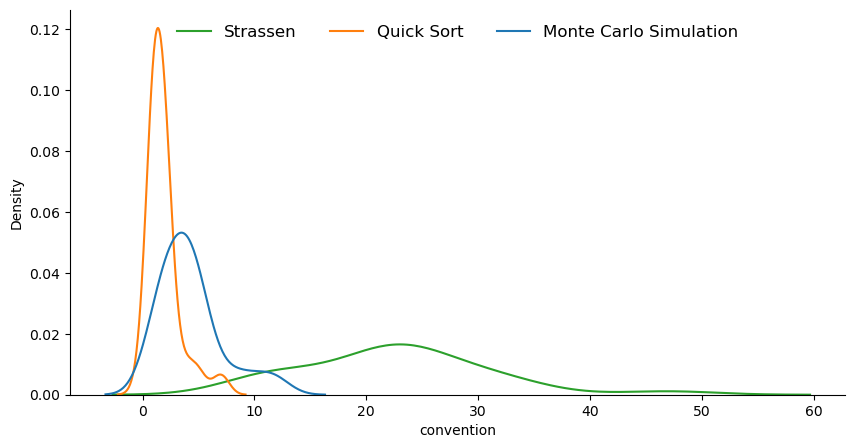

In [66]:
data = df_0[df_0.algorithm.isin([key for key,val in domain.items() if val == 'HPC'])]


#df_domain_maintainability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(figsize=(10, 5), sharex=True, sharey=True)

sns.kdeplot(data=data, x='convention', hue='algorithm', legend=True)
#axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
#axs[i].set_xlabel('Lines of Code Raw Count', fontsize=12)
#axs[i].text(0.95, distance, f"Average: {df_domain_maintainability[df_domain_maintainability.prompt == prompt]['convention'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs.legend(loc='upper center', ncol=3, labels=['Strassen', 'Quick Sort', 'Monte Carlo Simulation'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

del data

## Source Code


### Domain Exploration

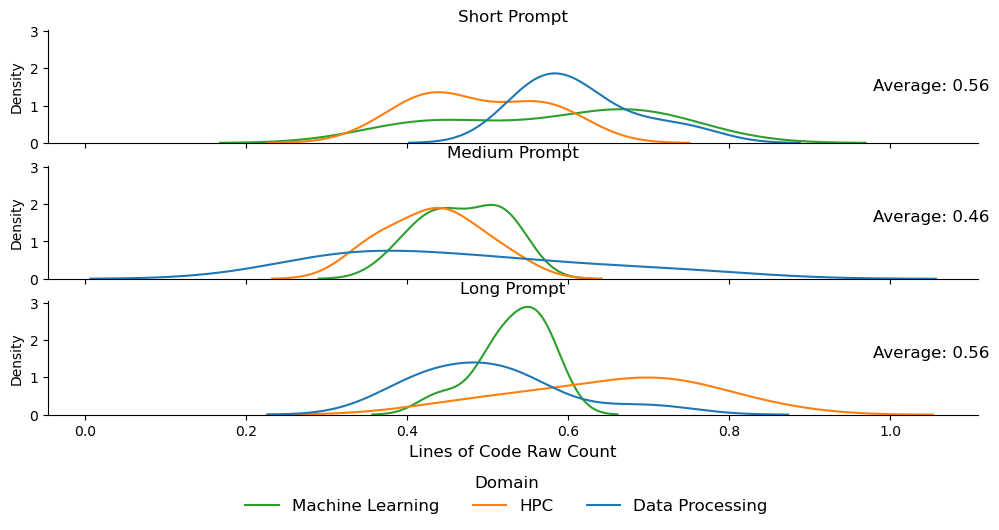

In [89]:
#df_domain_maintainability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='sloc_to_methods', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Lines of Code Raw Count', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_maintainability[df_domain_maintainability.prompt == prompt]['sloc_to_methods'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

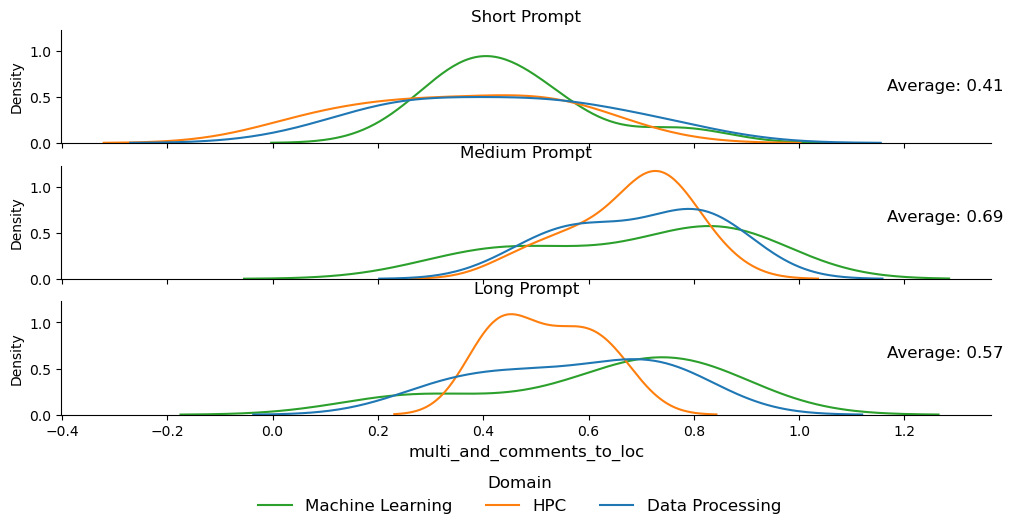

In [97]:
#df_domain_maintainability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='multi_and_comments_to_loc', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('multi_and_comments_to_loc', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_maintainability[df_domain_maintainability.prompt == prompt]['multi_and_comments_to_loc'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

### LLM

In [98]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_maintainability.pivot(index='model',columns='prompt',values='sloc_to_methods')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
#dfi.export(bugs_style, 'results_output/multi_and_comments_to_loc.png')

,short,medium,long,average,baseline
CLLam,0.48,0.57,0.58,0.54,0.66
CoX,0.55,0.41,0.50,0.49,0.66
DeSeCo,0.57,0.43,0.65,0.55,0.66
GPT35T,0.49,0.50,0.55,0.51,0.66
GPT4T,0.59,0.46,0.51,0.52,0.66
GeMi,0.63,0.44,0.55,0.54,0.66
MaCo,0.53,0.41,0.65,0.52,0.66
OpCoInt,0.67,0.47,0.56,0.57,0.66
WiCo,0.54,0.42,0.54,0.50,0.66
Average,0.56,0.46,0.57,0.53,0.66


In [99]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_maintainability.pivot(index='model',columns='prompt',values='multi_and_comments_to_loc')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
#dfi.export(bugs_style, 'results_output/multi_and_comments_to_loc.png')

,short,medium,long,average,baseline
CLLam,0.59,0.64,0.70,0.64,0.80
CoX,0.28,0.72,0.58,0.53,0.80
DeSeCo,0.39,0.82,0.73,0.65,0.80
GPT35T,0.19,0.65,0.48,0.44,0.80
GPT4T,0.55,0.74,0.70,0.66,0.80
GeMi,0.62,0.79,0.71,0.70,0.80
MaCo,0.47,0.66,0.42,0.52,0.80
OpCoInt,0.31,0.57,0.44,0.44,0.80
WiCo,0.31,0.59,0.40,0.43,0.80
Average,0.41,0.69,0.57,0.56,0.80


## Composite

In [101]:
df_maintainability['composite_score'] = ((df_maintainability['sloc_to_methods'] * 0.5 * 0.33) +
                                          (df_maintainability['multi_and_comments_to_loc'] * 0.5 * 0.33) +
                                          (df_maintainability['mi'] * 0.33) +
                                          (df_maintainability['refactor'] * 0.5 * 0.33) +
                                          (df_maintainability['convention'] * 0.5 * 0.33))

df_domain_maintainability['composite_score'] = ((df_domain_maintainability['sloc_to_methods'] * 0.5 * 0.33) +
                                          (df_domain_maintainability['multi_and_comments_to_loc'] * 0.5 * 0.33) +
                                          (df_domain_maintainability['mi'] * 0.33) +
                                          (df_domain_maintainability['refactor'] * 0.5 * 0.33) +
                                          (df_domain_maintainability['convention'] * 0.5 * 0.33))

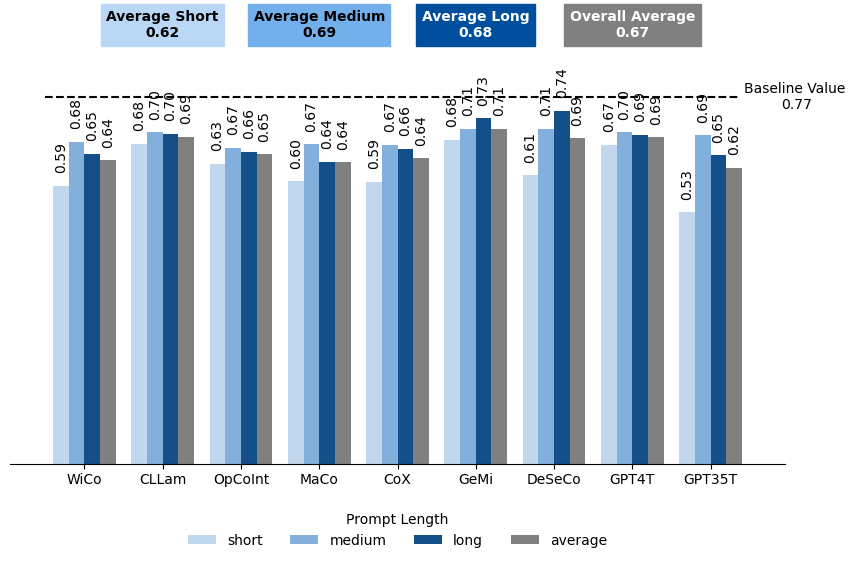

In [102]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.barplot(data=df_maintainability[(-df_maintainability.prompt.isin(['baseline'])) & (df_maintainability.model != 'Base')].sort_values(by='prompt', ascending=False),
            x='model', y='composite_score', hue='prompt', palette=prompt_palette)


baseline_value = df_maintainability[df_maintainability.model == 'Base']['composite_score'].values[0]
short_average = df_maintainability[df_maintainability.prompt == 'short']['composite_score'].mean()
medium_average = df_maintainability[df_maintainability.prompt == 'medium']['composite_score'].mean()
long_average = df_maintainability[df_maintainability.prompt == 'long']['composite_score'].mean()
overall_average = df_maintainability[df_maintainability.prompt == 'average']['composite_score'].mean()

# Removing y-axis
axs.set_ylabel('')
axs.set_yticks([])

# Format x-axis labels
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, ha='center')

# Add baseline line
axs.hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
axs.text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
axs.text(1, .9, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
axs.text(3, .9, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
axs.text(5, .9, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
axs.text(7, .9, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
axs.set_ylabel('')  # Remove y-axis label
axs.set_yticks([])  # Remove y-axis ticks
axs.set_xlabel('')  # Remove x-axis label

# Set legend position
axs.legend(bbox_to_anchor=(0.5, -0.25), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

sns.despine()
axs.spines['left'].set_visible(False)

# Add annotations to the bars
for p in axs.patches:
    axs.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')


plt.show()


# Performance Efficiency

In [108]:
# Partition dataframes for maintainability
df_performance = partion(df, efficiency_metrics)
df_domain_performance = partion(domain_df, efficiency_metrics, domain=True)

## Domain Exploration

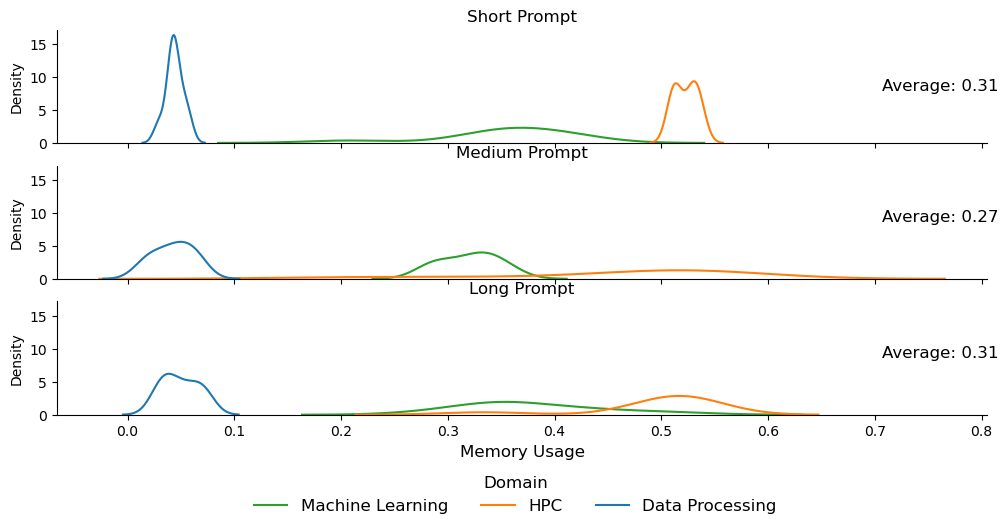

In [110]:
#df_domain_performance = df_raw[['domain','prompt','loc', 'model', 'memory_usage']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_performance[df_domain_performance.prompt == prompt], x='memory_usage', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Memory Usage', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_performance[df_domain_performance.prompt == prompt]['memory_usage'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

## LLM

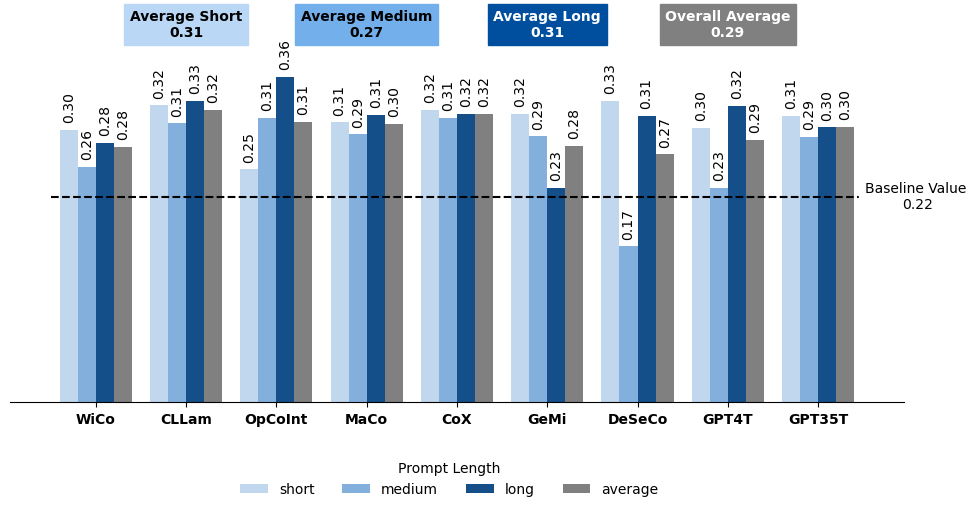

In [111]:
# Catplot
g = sns.catplot(data=df_performance[df_performance.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='memory_usage',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = df_performance[df_performance.model == 'Base']['memory_usage'].values[0]
short_average = df_performance[df_performance.prompt == 'short']['memory_usage'].mean()
medium_average = df_performance[df_performance.prompt == 'medium']['memory_usage'].mean()
long_average = df_performance[df_performance.prompt == 'long']['memory_usage'].mean()
overall_average = df_performance[df_performance.prompt == 'average']['memory_usage'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, .4, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, .4, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, .4, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, .4, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.01),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


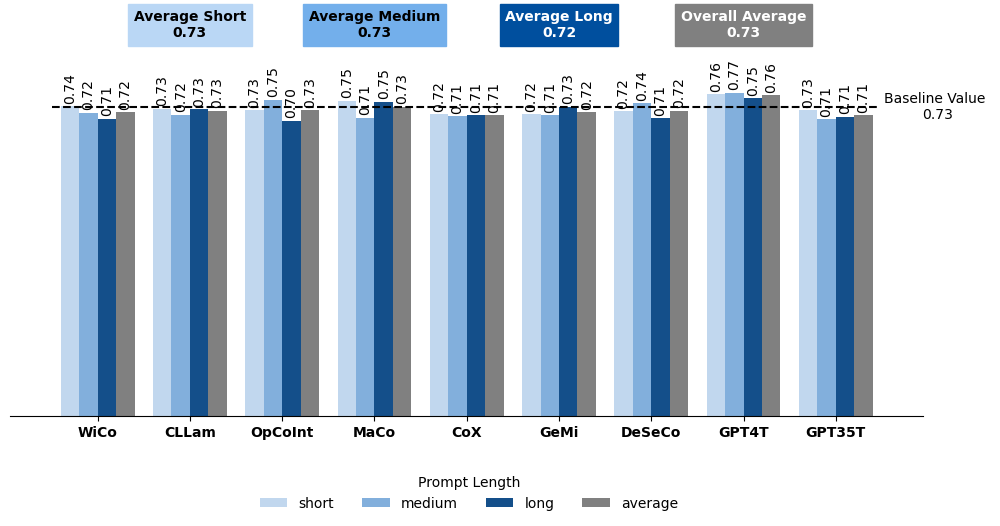

In [113]:
# Catplot
g = sns.catplot(data=df_performance[df_performance.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='cpu',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = df_performance[df_performance.model == 'Base']['cpu'].values[0]
short_average = df_performance[df_performance.prompt == 'short']['cpu'].mean()
medium_average = df_performance[df_performance.prompt == 'medium']['cpu'].mean()
long_average = df_performance[df_performance.prompt == 'long']['cpu'].mean()
overall_average = df_performance[df_performance.prompt == 'average']['cpu'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, .9, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, .9, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, .9, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, .9, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.01),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


## Composite

In [116]:
df_performance['composite_score'] = (df_performance['cpu'] * 0.5) + (df_performance['memory_usage'] * 0.5)

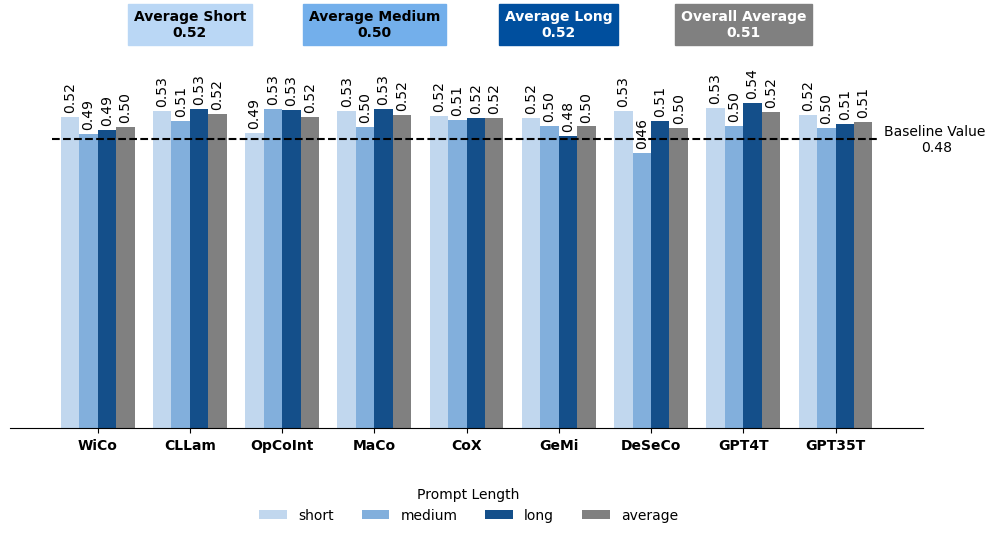

In [120]:
# Catplot
g = sns.catplot(data=df_performance[df_performance.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='composite_score',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = df_performance[df_performance.model == 'Base']['composite_score'].values[0]
short_average = df_performance[df_performance.prompt == 'short']['composite_score'].mean()
medium_average = df_performance[df_performance.prompt == 'medium']['composite_score'].mean()
long_average = df_performance[df_performance.prompt == 'long']['composite_score'].mean()
overall_average = df_performance[df_performance.prompt == 'average']['composite_score'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, .65, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, .65, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, .65, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, .65, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.01),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


# Reliability

In [121]:
# Partition dataframes for maintainability
df_reliability = partion(df, reliability_metrics)
df_domain_reliability = partion(domain_df, reliability_metrics, domain=True)

## Complexity And Bugs

### Domain Exploration

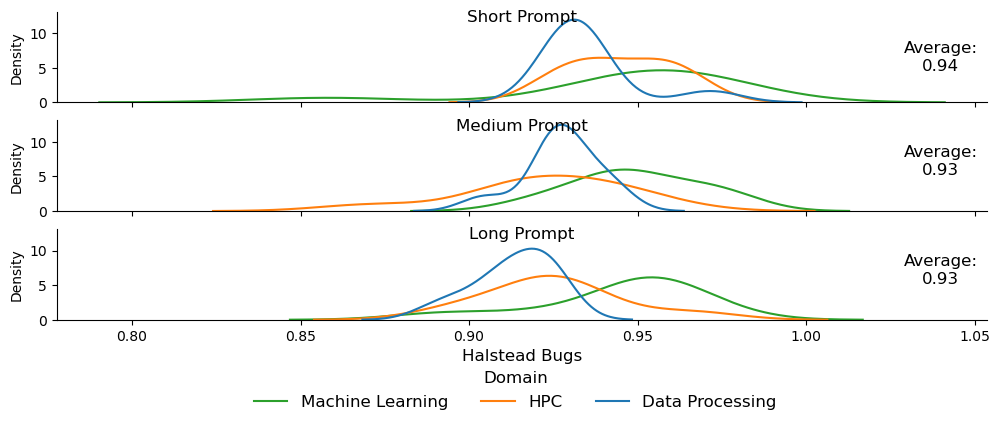

In [122]:
#df_domain_reliability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_reliability[df_domain_reliability.prompt == prompt], x='halstead_bugs', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light', y=0.8)
    axs[i].set_xlabel('Halstead Bugs', fontsize=12)
    axs[i].text(0.95, distance, f"Average:\n{df_domain_reliability[df_domain_reliability.prompt == prompt]['halstead_bugs'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

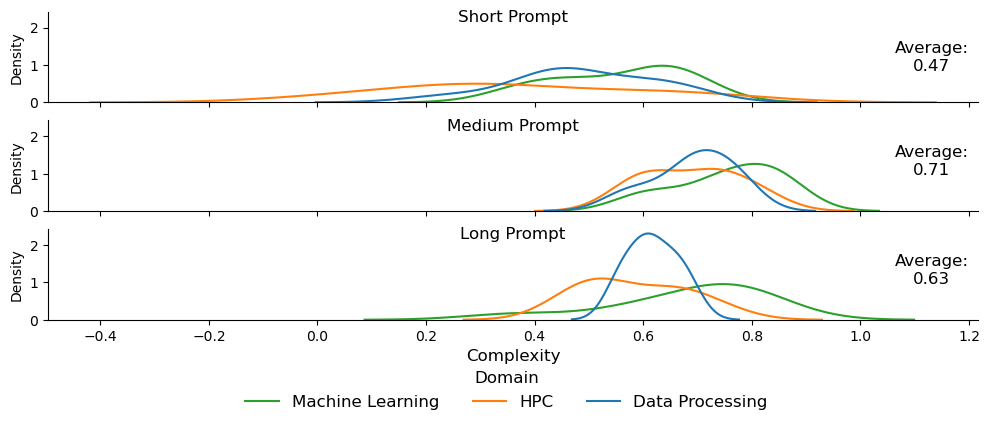

In [123]:
#df_domain_reliability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_reliability[df_domain_reliability.prompt == prompt], x='max_complexity', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light', y=0.8)
    axs[i].set_xlabel('Complexity', fontsize=12)
    axs[i].text(0.95, distance, f"Average:\n{df_domain_reliability[df_domain_reliability.prompt == prompt]['max_complexity'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

### LLM

In [126]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_reliability.pivot(index='model',columns='prompt',values='halstead_bugs')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style

,short,medium,long,average,baseline
CLLam,0.97,0.93,0.92,0.94,0.88
CoX,0.95,0.94,0.92,0.93,0.88
DeSeCo,0.94,0.95,0.94,0.94,0.88
GPT35T,0.95,0.95,0.93,0.95,0.88
GPT4T,0.94,0.93,0.91,0.93,0.88
GeMi,0.91,0.91,0.94,0.92,0.88
MaCo,0.93,0.93,0.92,0.93,0.88
OpCoInt,0.95,0.94,0.91,0.93,0.88
WiCo,0.95,0.94,0.94,0.94,0.88
Average,0.94,0.93,0.93,0.93,0.88


In [124]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_reliability.pivot(index='model',columns='prompt',values='max_complexity')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style

,short,medium,long,average,baseline
CLLam,0.56,0.71,0.70,0.66,0.71
CoX,0.33,0.67,0.53,0.51,0.71
DeSeCo,0.37,0.78,0.66,0.60,0.71
GPT35T,0.36,0.71,0.65,0.57,0.71
GPT4T,0.65,0.78,0.64,0.69,0.71
GeMi,0.68,0.79,0.71,0.73,0.71
MaCo,0.47,0.64,0.51,0.55,0.71
OpCoInt,0.37,0.60,0.63,0.53,0.71
WiCo,0.45,0.72,0.64,0.60,0.71
Average,0.47,0.71,0.63,0.60,0.71


## Python Specific Reliability

### Domain Exploration

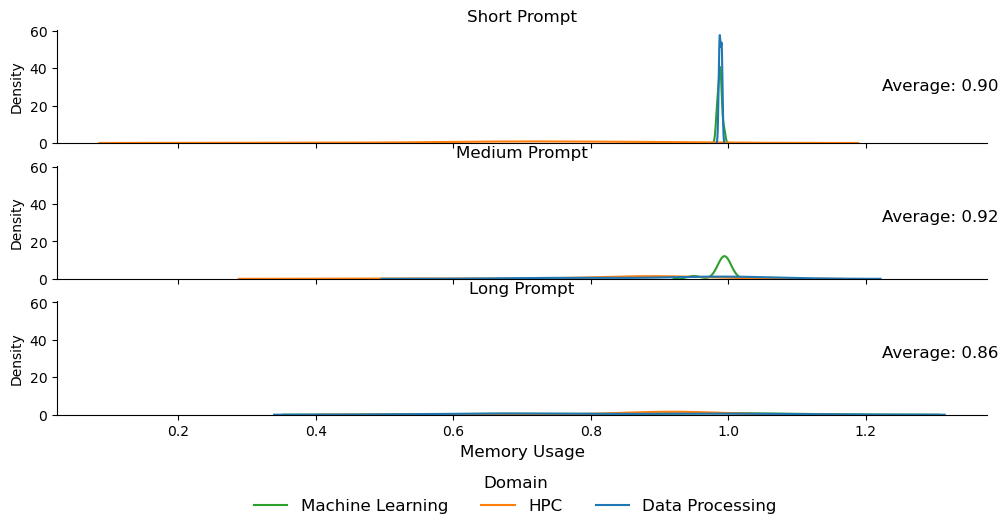

In [147]:
#df_domain_reliability = df_raw[['domain','prompt','loc', 'model', 'error']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_reliability[df_domain_reliability.prompt == prompt], x='errors', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Memory Usage', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_reliability[df_domain_reliability.prompt == prompt]['errors'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

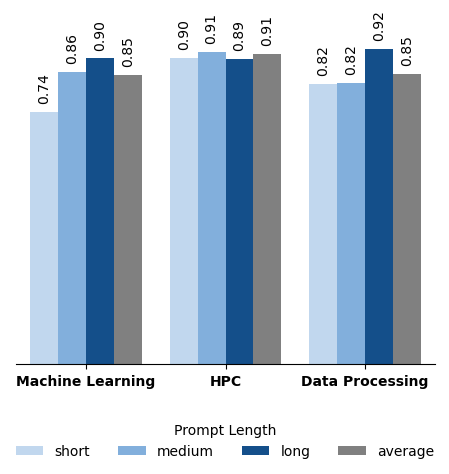

In [129]:
# Catplot
g = sns.catplot(data=df_domain_reliability[-df_domain_reliability.prompt.isin(['baseline'])].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='domain',
                y='warnings',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(5, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
g.figure.axes[0].set_ylim(0, 1)
# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


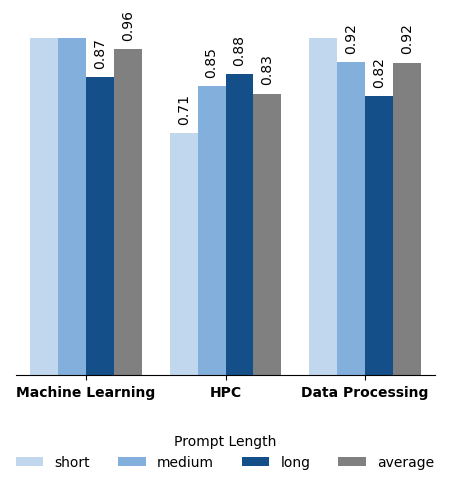

In [128]:
# Catplot
g = sns.catplot(data=df_domain_reliability[-df_domain_reliability.prompt.isin(['baseline'])].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='domain',
                y='errors',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(5, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
g.figure.axes[0].set_ylim(0, 1)
# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


### LLM

In [130]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_reliability.pivot(index='model',columns='prompt',values='warnings')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style

,short,medium,long,average,baseline
CLLam,0.66,0.73,0.91,0.77,0.92
CoX,0.74,0.97,0.98,0.90,0.92
DeSeCo,0.90,0.86,0.97,0.91,0.92
GPT35T,0.82,0.74,0.86,0.81,0.92
GPT4T,0.94,0.98,0.99,0.97,0.92
GeMi,0.86,0.99,0.93,0.93,0.92
MaCo,0.77,0.71,0.74,0.74,0.92
OpCoInt,0.79,0.92,0.95,0.89,0.92
WiCo,0.89,0.88,0.86,0.88,0.92
Average,0.82,0.87,0.91,0.86,0.92


In [131]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_reliability.pivot(index='model',columns='prompt',values='errors')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style

,short,medium,long,average,baseline
CLLam,0.96,0.89,0.76,0.87,0.97
CoX,0.88,0.95,0.96,0.93,0.97
DeSeCo,0.79,0.96,0.86,0.87,0.97
GPT35T,0.88,0.76,0.75,0.80,0.97
GPT4T,0.94,0.97,0.98,0.96,0.97
GeMi,0.95,0.96,0.74,0.88,0.97
MaCo,0.91,0.86,0.87,0.89,0.97
OpCoInt,0.88,0.95,0.95,0.93,0.97
WiCo,0.88,0.96,0.84,0.89,0.97
Average,0.90,0.92,0.86,0.89,0.97


## Composite

In [132]:
reliability_composite = lambda x: x['errors'] * 0.25 + x['halstead_bugs'] * 0.25 + x['max_complexity'] * 0.25 + x['warnings'] * 0.25
df_reliability['composite_score'] = reliability_composite(df_reliability)

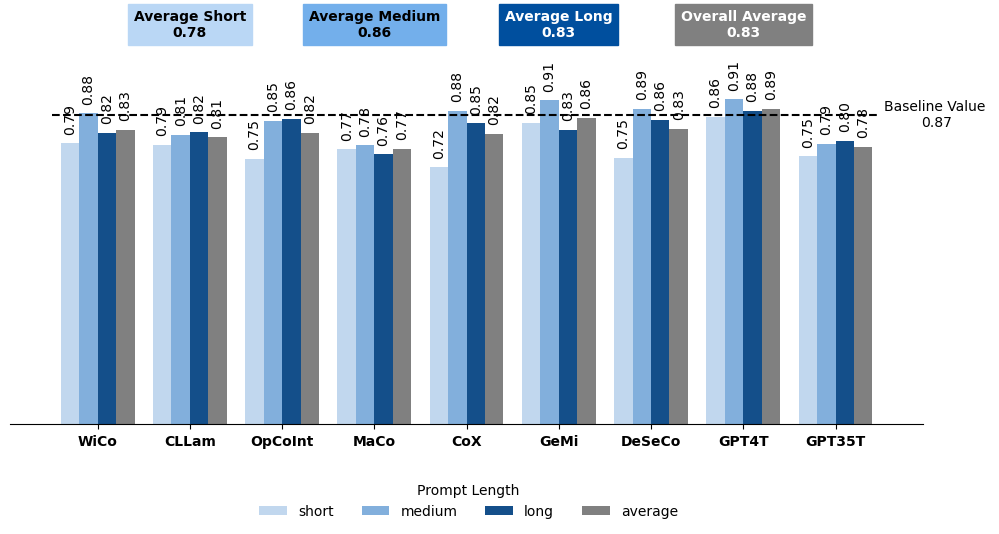

In [133]:
# Catplot
g = sns.catplot(data=df_reliability[df_reliability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='composite_score',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = df_reliability[df_reliability.model == 'Base']['composite_score'].values[0]
short_average = df_reliability[df_reliability.prompt == 'short']['composite_score'].mean()
medium_average = df_reliability[df_reliability.prompt == 'medium']['composite_score'].mean()
long_average = df_reliability[df_reliability.prompt == 'long']['composite_score'].mean()
overall_average = df_reliability[df_reliability.prompt == 'average']['composite_score'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


# Security

In [143]:
# Partition dataframes for security
df_security = partion(df, security_metrics)
df_security['composite'] = df_security.security_low * 0.33 + df_security.warnings * 0.33 + df_security.errors * 0.33


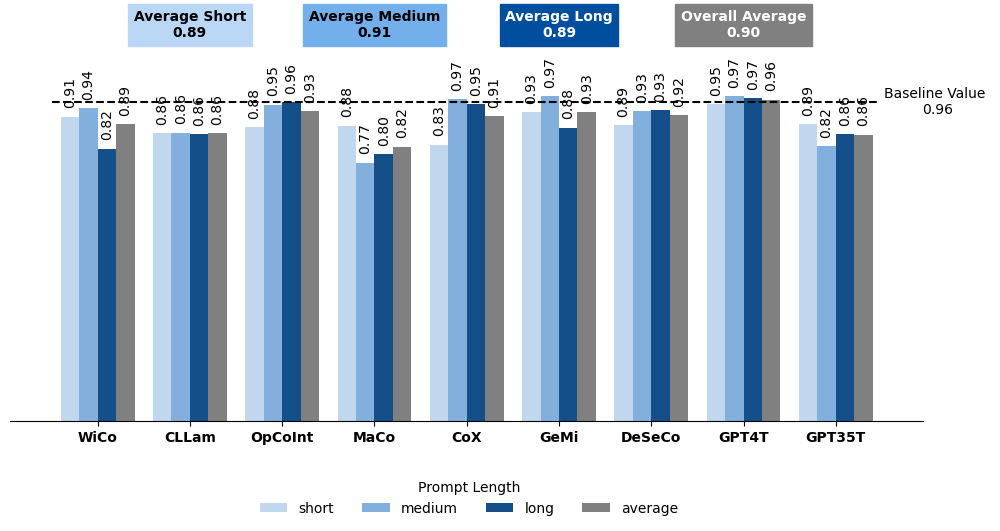

In [144]:
# Catplot
g = sns.catplot(data=df_security[df_security.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='composite',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = df_security[df_security.model == 'Base']['composite'].values[0]
short_average = df_security[df_security.prompt == 'short']['composite'].mean()
medium_average = df_security[df_security.prompt == 'medium']['composite'].mean()
long_average = df_security[df_security.prompt == 'long']['composite'].mean()
overall_average = df_security[df_security.prompt == 'average']['composite'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.15, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.15, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.15, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.15, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()
